# XCEPTION Cervical Cancer Classification

In [37]:
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint
from keras import backend as k

from skimage.io import imread, imshow
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Short Data Exploration

In [19]:
from glob import glob
basepath = 'data/train/'

all_cervix_images = []

for path in sorted(glob(basepath + "*")):
    cervix_type = path.split("/")[-1]
    cervix_images = sorted(glob(basepath + cervix_type + "/*"))
    all_cervix_images = all_cervix_images + cervix_images

all_cervix_images = pd.DataFrame({'imagepath': all_cervix_images})
all_cervix_images['filetype'] = all_cervix_images.apply(lambda row: row.imagepath.split(".")[-1], axis=1)
all_cervix_images['type'] = all_cervix_images.apply(lambda row: row.imagepath.split("/")[-2], axis=1)
all_cervix_images.head()

,imagepath,filetype,type
0,data/train/Type_1/0.jpg,jpg,Type_1
1,data/train/Type_1/10.jpg,jpg,Type_1
2,data/train/Type_1/1013.jpg,jpg,Type_1
3,data/train/Type_1/1014.jpg,jpg,Type_1
4,data/train/Type_1/1019.jpg,jpg,Type_1


We have a total of 1481 images in the whole dataset


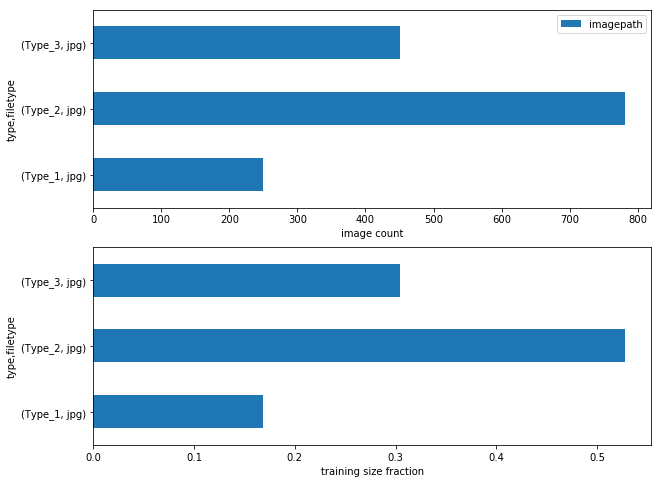

In [24]:
print('We have a total of {} images in the whole dataset'.format(all_cervix_images.shape[0]))
type_aggregation = all_cervix_images.groupby(['type', 'filetype']).agg('count')
type_aggregation_p = type_aggregation.apply(lambda row: 1.0*row['imagepath']/all_cervix_images.shape[0], axis=1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

type_aggregation.plot.barh(ax=axes[0])
axes[0].set_xlabel("image count")
type_aggregation_p.plot.barh(ax=axes[1])
axes[1].set_xlabel("training size fraction")

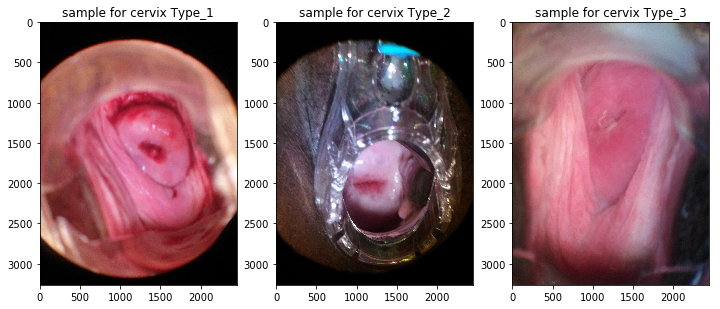

In [25]:
fig = plt.figure(figsize=(12,8))

i = 1
for t in all_cervix_images['type'].unique():
    ax = fig.add_subplot(1,3,i)
    i+=1
    f = all_cervix_images[all_cervix_images['type'] == t]['imagepath'].values[0]
    plt.imshow(plt.imread(f))
    plt.title('sample for cervix {}'.format(t))

## Image dimensions

In [34]:
from collections import defaultdict

images = defaultdict(list)

for t in all_cervix_images['type'].unique():
    sample_counter = 0
    for _, row in all_cervix_images[all_cervix_images['type'] == t].iterrows():
        #print('reading image {}'.format(row.imagepath))
        try:
            img = imread(row.imagepath)
            sample_counter +=1
            images[t].append(img)
        except:
            print('image read failed for {}'.format(row.imagepath))
        if sample_counter > 35:
            break

In [35]:
dfs = []
for t in all_cervix_images['type'].unique():
    t_ = pd.DataFrame(
        {
            'nrows': list(map(lambda i: i.shape[0], images[t])),
            'ncols': list(map(lambda i: i.shape[1], images[t])),
            'nchans': list(map(lambda i: i.shape[2], images[t])),
            'type': t
        }
    )
    dfs.append(t_)

shapes_df = pd.concat(dfs, axis=0)
shapes_df_grouped = shapes_df.groupby(by=['nchans', 'ncols', 'nrows', 'type']).size().reset_index().sort_values(['type', 0], ascending=False)
shapes_df_grouped

,nchans,ncols,nrows,type,0
3,3,2448,3264,Type_3,28
6,3,3096,4128,Type_3,7
7,3,3264,2448,Type_3,1
5,3,3096,4128,Type_2,18
2,3,2448,3264,Type_2,17
8,3,4128,3096,Type_2,1
1,3,2448,3264,Type_1,18
4,3,3096,4128,Type_1,17
0,3,2322,4128,Type_1,1


/home/paperspace/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


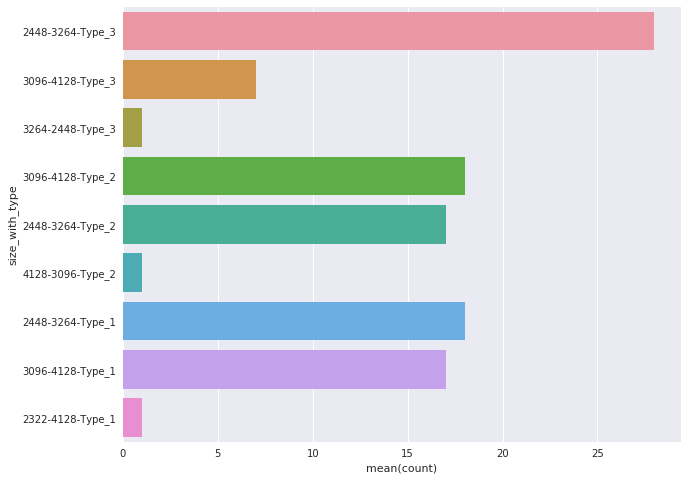

In [38]:
shapes_df_grouped['size_with_type'] = shapes_df_grouped.apply(lambda row: '{}-{}-{}'.format(row.ncols, row.nrows, row.type), axis=1)
shapes_df_grouped = shapes_df_grouped.set_index(shapes_df_grouped['size_with_type'].values)
shapes_df_grouped['count'] = shapes_df_grouped[[0]]

plt.figure(figsize=(10,8))
#shapes_df_grouped['count'].plot.barh(figsize=(10,8))
sns.barplot(x="count", y="size_with_type", data=shapes_df_grouped)

## Image neighbourhood

We will now take all of the sample images, rescale them & convert them to grayscale. This will result in a matrix, where each row are all flattened pixel for the grayscale images.
The original images have, as we have seen earlier, quite a high resolution, so scaling them down to 100 x 100 is resulting in a great loss of information, so the embedding to two dimensions is likely not going to have a good structure where we can separate visually by cervical cancer types. Also, we are giving only very few images per class that TSNE can work with to find a good, distance preserving, embedding.
I've added the option to choose to convert them to grayscale before passing them to TSNE. Per default each image will now keep its RGB information and therefore will be transformed to a 1001003 = 30.000 dimensional vector.

In [41]:
def transform_image(img, rescaled_dim, to_gray=False):
    resized = cv2.resize(img, (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR)

    if to_gray:
        resized = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY).astype('float')
    else:
        resized = resized.astype('float')

    normalized = cv2.normalize(resized, None, 0.0, 1.0, cv2.NORM_MINMAX)
    timg = normalized.reshape(1, np.prod(normalized.shape))

    return timg/np.linalg.norm(timg)

rescaled_dim = 100

all_images = []
all_image_types = []

for t in all_cervix_images['type'].unique():
    all_images = all_images + images[t]
    all_image_types = all_image_types + len(images[t])*[t]

# - normalize each uint8 image to the value interval [0, 1] as float image
# - rgb to gray
# - downsample image to rescaled_dim X rescaled_dim
# - L2 norm of each sample = 1
gray_all_images_as_vecs = [transform_image(img, rescaled_dim) for img in all_images]

gray_imgs_mat = np.array(gray_all_images_as_vecs).squeeze()
all_image_types = np.array(all_image_types)
gray_imgs_mat.shape, all_image_types.shape

((108, 30000), (108,))

In [42]:
from scipy.spatial.distance import pdist, squareform

sq_dists = squareform(pdist(gray_imgs_mat))

/home/paperspace/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


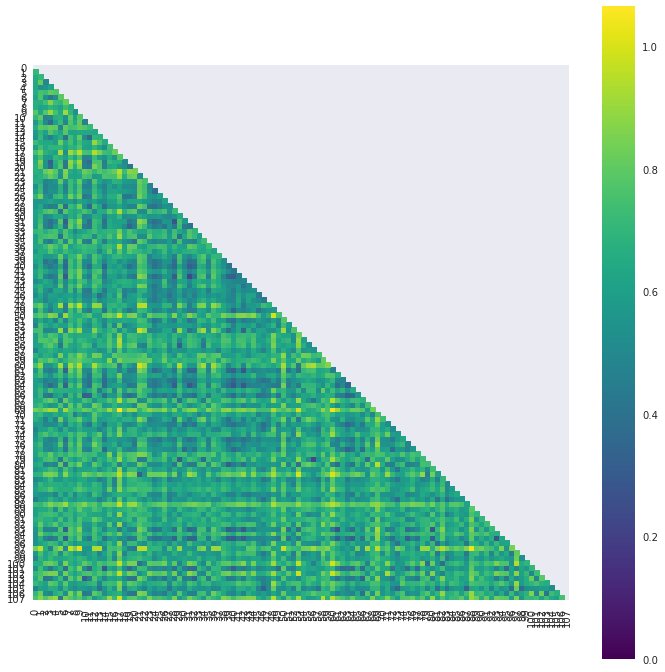

In [44]:
mask = np.zeros_like(sq_dists, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(12,12))
sns.heatmap(sq_dists, cmap=plt.get_cmap('viridis'), square=True, mask=mask)

/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: Mean of empty slice
/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: Mean of empty slice


/home/paperspace/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


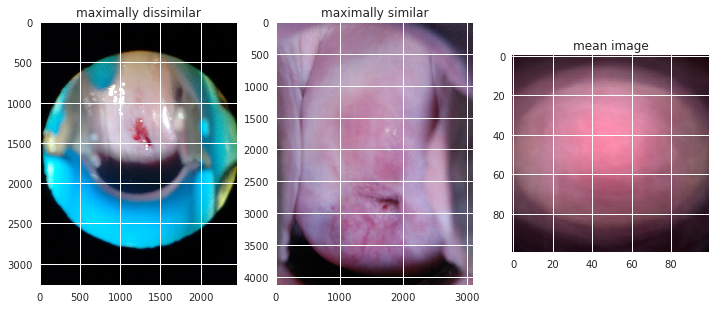

In [45]:
# upper triangle of matrix set to np.nan
sq_dists[np.triu_indices_from(mask)] = np.nan
sq_dists[0, 0] = np.nan

fig = plt.figure(figsize=(12,8))
# maximally dissimilar image
ax = fig.add_subplot(1,3,1)
maximally_dissimilar_image_idx = np.nanargmax(np.nanmean(sq_dists, axis=1))
plt.imshow(all_images[maximally_dissimilar_image_idx])
plt.title('maximally dissimilar')

# maximally similar image
ax = fig.add_subplot(1,3,2)
maximally_similar_image_idx = np.nanargmin(np.nanmean(sq_dists, axis=1))
plt.imshow(all_images[maximally_similar_image_idx])
plt.title('maximally similar')

# now compute the mean image
ax = fig.add_subplot(1,3,3)
mean_img = gray_imgs_mat.mean(axis=0).reshape(rescaled_dim, rescaled_dim, 3)
plt.imshow(cv2.normalize(mean_img, None, 0.0, 1.0, cv2.NORM_MINMAX))
plt.title('mean image')

# NN

In [2]:
train_data_dir = 'data/train'
test_data_dir = 'data/test'

top_model_weights_path = 'my_xception.h5'
results_path = 'results/predictions'
results_name = 'predictions.csv'


nb_train_samples = 24198
nb_validation_samples = 802

In [3]:
# hyper parameters for model
nb_classes = 2  # number of classes
based_model_last_block_layer_number = 126  # value is based on based model selected.
img_width, img_height = 150, 150  # change based on the shape/structure of your images
batch_size = 16  # try 4, 8, 16, 32, 64, 128, 256 dependent on CPU/GPU memory capacity (powers of 2 values).
nb_epoch = 3  # number of iteration the algorithm gets trained.
learn_rate = 1e-4  # sgd learning rate
momentum = .9  # sgd momentum to avoid local minimum
transformation_ratio = .05  # how aggressive will be the data augmentation/transformation

In [4]:
# Pre-Trained CNN Model using imagenet dataset for pre-trained weights
base_model = Xception(input_shape=(img_width, img_height, 3), weights='imagenet', include_top=False)
print('Model Loaded!')

Model Loaded!


In [5]:
# Top Model Block
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(nb_classes, activation='softmax')(x)

In [6]:
# add your top layer block to your base model
model = Model(base_model.input, predictions)

In [7]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all layers of the based model that is already pre-trained.
for layer in base_model.layers:
    layer.trainable = False